In [295]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 63.2MB/s]


Imports

In [328]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import time

In [329]:
test1 = glob.glob("/content/CIFAR10/test/airplane/*.jpg")
test2 = glob.glob("/content/CIFAR10/test/automobile/*.jpg")
test3 = glob.glob("/content/CIFAR10/test/bird/*.jpg")
test4 = glob.glob("/content/CIFAR10/test/cat/*.jpg")

train1 = glob.glob("/content/CIFAR10/train/airplane/*.jpg")
train2 = glob.glob("/content/CIFAR10/train/automobile/*.jpg")
train3 = glob.glob("/content/CIFAR10/train/bird/*.jpg")
train4 = glob.glob("/content/CIFAR10/train/cat/*.jpg")

# print(test1)

In [331]:
def readImages(images_path):
  images = []
  for path in images_path:
    images.append(np.asarray(plt.imread(path)))
  
  return images

test = np.array(readImages(test1) + readImages(test2) + readImages(test3)  + readImages(test4))
train = np.array(readImages(train1) + readImages(train2) + readImages(train3) + readImages(train4))

print(test.shape, train.shape)

def addLabel(size):
  l1 = [[1,0,0,0] for i in range(size//4)]
  l2 = [[0,1,0,0] for i in range(size//4)]
  l3 = [[0,0,1,0] for i in range(size//4)]
  l4 = [[0,0,0,1] for i in range(size//4)]

  # print(l1)

  return np.array(l1 + l2 + l3 + l4)

test_label = addLabel(4000)
train_label = addLabel(20000)

print(test_label.shape)

(4000, 32, 32, 3) (20000, 32, 32, 3)
(4000, 4)


In [299]:
def rgb2gray(rgb):
  r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

test = rgb2gray(test)
train = rgb2gray(train)

print(test.shape, train.shape)

(4000, 32, 32) (20000, 32, 32)


Normalize and Flat

In [300]:
test = test / 255
train = train / 255

print(test.shape, train.shape)

test = test.reshape(-1,1024)
train = train.reshape(-1,1024)
print(test.shape, train.shape)

(4000, 32, 32) (20000, 32, 32)
(4000, 1024) (20000, 1024)


Shuffle

In [301]:
def shuffleMatrix(a, b): # https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]

test, test_label = shuffleMatrix(test, test_label)
train, train_label = shuffleMatrix(train, train_label)

print(test.shape, train.shape)

(4000, 1024) (20000, 1024)


In [302]:
w0 = np.random.normal(size=(16,1024)) # k = 16, n = 1024
w1 = np.random.normal(size=(16, 16)) # k = 16, n = 16
w2 = np.random.normal(size=(4, 16)) # k = 4, n = 16
b0 = np.zeros((16, 1))
b1 = np.zeros((16, 1))
b2 = np.zeros((4, 1))

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

#return index of max element in array
def maxValueIndex(array):
  max_value = np.max(array)
  index = np.where(array == max_value)
  return index[0]

#feedForward
images_number = 200
counter = 0
for i in range(images_number):
  first_hidden_layyer_output = sigmoid(np.matmul(w0, train[i]) + b0)
  second_hidden_layyer_output = sigmoid(np.matmul(w1, first_hidden_layyer_output) + b1)
  output = sigmoid(np.matmul(w2, second_hidden_layyer_output) + b2)

  if maxValueIndex(output).any() == maxValueIndex(train_label[i]):
    counter += 1

print('Accuracy: ', counter/images_number)

Accuracy:  0.245


In [303]:
train_set = []
test_set = []

batch_size = 16
learning_rate = 0.3
epochs_number = 10

#create sets of (Image,Lable)
for i in range(4000):
  test_set.append((test[i, :].T.reshape(1024, 1), test_label[i, :].T.reshape(4, 1)))

for i in range(20000):
  train_set.append((train[i, :].T.reshape(1024, 1), train_label[i, :].T.reshape(4, 1)))
batches = [train_set[j:j+batch_size] for j in range(0, 200, batch_size)]

In [304]:
def sigmoid_deriv(a):
    return sigmoid(a) * (1 - sigmoid(a))

def deriv(sig_a):
  return sig_a * (1 - sig_a)

timer = 0
costs = []
for i in range(epochs_number):
    timer = time.time()
    # random.shuffle(train_set)
    # batches = [train_set[j:j+batch_size] for j in range(0, 200, batch_size)]
    for batch in batches:
        grad_w0 = np.zeros((16,1024)) # k = 16, n = 1024
        grad_w1 = np.zeros((16, 16)) # k = 16, n = 16
        grad_w2 = np.zeros((4, 16)) # k = 4, n = 16
        grad_b0 = np.zeros((16, 1))
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((4, 1))


        for b in batch:
            image = b[0]
            label = b[1]
            b0 = b0.reshape(16,1)
            b1 = b1.reshape(16,1)
            b2 = b2.reshape(4,1)

            z1 = np.matmul(w0, image) + b0
            a1 = sigmoid(z1)

            z2 = np.matmul(w1, a1) + b1
            a2 = sigmoid(z2)

            z3 = np.matmul(w2, a2) + b2
            a3 = sigmoid(z3)
            

            #last layer
            for j in range(grad_w2.shape[0]):
                for k in range(grad_w2.shape[1]):
                    grad_w2[j][k] +=  a2[k][0] * deriv(a3[j][0])  * (2 * a3[j][0] - 2 * label[j][0])
            
        
            for j in range(grad_b2.shape[0]):
                    grad_b2[j][0] +=  deriv(a3[j][0]) * (2 * a3[j][0] - 2 * label[j][0]) 
            

            # second hidden layer
            g2 = np.zeros((16, 1))
            for k in range(16):
                for j in range(4):
                    g2[k][0] += w2[j][k] * deriv(a3[j][0]) * (2 * a3[j][0] - 2 * label[j][0]) 
            
            for j in range(grad_w1.shape[0]):
                for k in range(grad_w2.shape[1]):
                    grad_w1[j][k] += a1[k][0] * g2[k][0] * deriv(a2[j][0])
            
            
            for k in range(grad_b1.shape[0]):
                    grad_b1[k, 0] += g2[k][0] * deriv(a2[k][0])
                    
            # first hidden layer
            g1 = np.zeros((16, 1))
            for k in range(16):
                for j in range(16):
                    g1[k][0] += w1[j][k] * deriv(a2[j][0]) * g2[j][0]
            
            
            for j in range(grad_w0.shape[0]):
                for k in range(grad_w0.shape[1]):
                    grad_w0[j, k] += image[k][0] * deriv(a1[j][0]) * g1[j][0]

            for m in range(grad_b0.shape[0]):
                grad_b0[m][0] += g1[m][0] * deriv(a1[j][0])
            
        w2 = w2 - (learning_rate * (grad_w2 / batch_size))
        w1 = w1 - (learning_rate * (grad_w1 / batch_size))
        w0 = w0 - (learning_rate * (grad_w0 / batch_size))
        
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
        b0 = b0 - (learning_rate * (grad_b0 / batch_size))

    # print('XXXX')
    cost = 0
    correct_guess = 0
    for data in train_set[:images_number]:
        image = data[0]
        label = data[1]
        a1 = sigmoid(np.matmul(w0, image) + b0)
        a2 = sigmoid(np.matmul(w1, a1) + b1)
        a3 = sigmoid(np.matmul(w2, a2) + b2)

        for j in range(4):
              cost = cost + ((a3[j, 0] - label[j,  0]) ** 2)
              
    costs.append(cost / images_number)  
stop = time.time()
            
            

10
Running Time Is:  12.20392370223999
Accuracy: 0.32


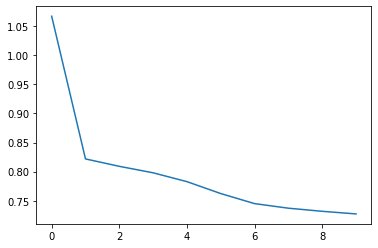

In [305]:

epoch_size = [x for x in range(epochs_number)]
print(len(costs))
plt.plot(epoch_size, costs)

for train_data in train_set[:images_number]:
    image = train_data[0]
    lable = train_data[1]
    a1 = sigmoid(w0 @ image + b0)
    a2 = sigmoid(w1 @ a1 + b1)
    a3 = sigmoid(w2 @ a2 + b2)
    
    
    if maxValueIndex(a3) == maxValueIndex(lable):
        correct_guess += 1
print("Running Time Is: ", stop - timer)
print("Accuracy:" ,correct_guess / 200)   

Vectorization

In [323]:
w0 = np.random.normal(size=(16,1024)) # k = 16, n = 1024
w1 = np.random.normal(size=(16, 16)) # k = 16, n = 16
w2 = np.random.normal(size=(4, 16)) # k = 4, n = 16
b0 = np.zeros((16, 1))
b1 = np.zeros((16, 1))
b2 = np.zeros((4, 1))

costs = []
def sigmoid_deriv(a):
    return sigmoid(a) * (1 - sigmoid(a))

def deriv(sig_a):
  return sig_a * (1 - sig_a)

timer = 0
epochs_number = 20
# all_costs = []
# all_guesses = []
# for n in range(10):
costs = []
for i in range(epochs_number):
    timer = time.time()
    np.random.shuffle(train_set)
    batches = [train_set[j:j+batch_size] for j in range(0, 200, batch_size)]
    for batch in batches:
        grad_w0 = np.zeros((16,1024)) # k = 16, n = 1024
        grad_w1 = np.zeros((16, 16)) # k = 16, n = 16
        grad_w2 = np.zeros((4, 16)) # k = 4, n = 16
        grad_b0 = np.zeros((16, 1))
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((4, 1))


        for b in batch:
            image = b[0]
            label = b[1]
            b0 = b0.reshape(16,1)
            b1 = b1.reshape(16,1)
            b2 = b2.reshape(4,1)

            z1 = np.matmul(w0, image) + b0
            a1 = sigmoid(z1)

            z2 = np.matmul(w1, a1) + b1
            a2 = sigmoid(z2)

            z3 = np.matmul(w2, a2) + b2
            a3 = sigmoid(z3)
            # print(a3.shape)

            #last layer
            grad_w2 +=  deriv(a3)  * (2 * a3 - 2 * label) @ np.transpose(a2)
            
            grad_b2 +=  deriv(a3) * 2 * (a3 - label) 
            

            # second hidden layer
            g2 = np.zeros((16, 1))
            g2 += np.transpose(w2) @ ((2 * (a3 - label)) * deriv(a3))

            grad_w1 += np.transpose(a1) @ g2 * deriv(a2)

            grad_b1 += g2 * deriv(a2)
                    
            # first hidden layer
            g1 = np.zeros((16, 1))
            g1 += np.transpose(w1) @ deriv(a2) * g2

            grad_w0 += (deriv(a1) * g1) @ np.transpose(image)

            grad_b0 += g1 * deriv(a1)
            
        w2 = w2 - (learning_rate * (grad_w2 / batch_size))
        w1 = w1 - (learning_rate * (grad_w1 / batch_size))
        w0 = w0 - (learning_rate * (grad_w0 / batch_size))
        
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
        b0 = b0 - (learning_rate * (grad_b0 / batch_size))

    # print('XXXX')
    cost = 0
    correct_guess = 0
    for data in train_set[:images_number]:
        image = data[0]
        label = data[1]
        a1 = sigmoid(np.matmul(w0, image) + b0)
        a2 = sigmoid(np.matmul(w1, a1) + b1)
        a3 = sigmoid(np.matmul(w2, a2) + b2)

        for j in range(4):
              cost = cost + ((a3[j, 0] - label[j,  0]) ** 2)

        if maxValueIndex(a3) == maxValueIndex(lable):
            correct_guess += 1
    costs.append(cost / images_number)  
stop = time.time()

    # all_costs.append(costs)
    # all_guesses.append(correct_guess)
  

In [311]:
# final_costs = []
# final_guess = 0
# for j in range(epochs_number):
#     x = 0
#     for i in range(10):
#       x += all_costs[i][j] / 10
#     final_costs.append(x)
# m = []
# for i in range(10):
#     final_guess += all_guesses[i]
#     m += all_costs[i]
# final_guess /= 10

# print(final_costs)
# print(final_guess)
# print(all_costs)

20
Running Time Is:  0.08242535591125488
Accuracy: 0.265


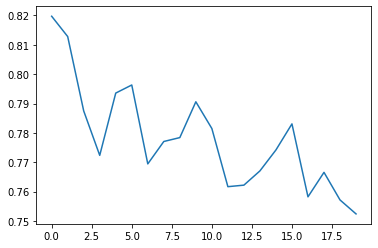

In [324]:
epoch_size = [x for x in range(epochs_number)]
print(len(costs))
plt.plot(epoch_size, costs)
    
print("Running Time Is: ", stop - timer)
print("Accuracy:" ,correct_guess / images_number)  

Testing - Train Set

In [313]:
w0 = np.random.normal(size=(16,1024)) # k = 16, n = 1024
w1 = np.random.normal(size=(16, 16)) # k = 16, n = 16
w2 = np.random.normal(size=(4, 16)) # k = 4, n = 16
b0 = np.zeros((16, 1))
b1 = np.zeros((16, 1))
b2 = np.zeros((4, 1))

costs = []
def sigmoid_deriv(a):
    return sigmoid(a) * (1 - sigmoid(a))

def deriv(sig_a):
  return sig_a * (1 - sig_a)

timer = 0
epochs_number = 40
# all_costs = []
# all_guesses = []
# for n in range(10):
costs = []
for i in range(epochs_number):
    timer = time.time()
    np.random.shuffle(train_set)
    batches = [train_set[j:j+batch_size] for j in range(0, len(train_set), batch_size)]
    for batch in batches:
        grad_w0 = np.zeros((16,1024)) # k = 16, n = 1024
        grad_w1 = np.zeros((16, 16)) # k = 16, n = 16
        grad_w2 = np.zeros((4, 16)) # k = 4, n = 16
        grad_b0 = np.zeros((16, 1))
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((4, 1))


        for b in batch:
            image = b[0]
            label = b[1]
            b0 = b0.reshape(16,1)
            b1 = b1.reshape(16,1)
            b2 = b2.reshape(4,1)

            z1 = np.matmul(w0, image) + b0
            a1 = sigmoid(z1)

            z2 = np.matmul(w1, a1) + b1
            a2 = sigmoid(z2)

            z3 = np.matmul(w2, a2) + b2
            a3 = sigmoid(z3)
            # print(a3.shape)

            #last layer
            grad_w2 +=  deriv(a3)  * (2 * a3 - 2 * label) @ np.transpose(a2)
            
            grad_b2 +=  deriv(a3) * 2 * (a3 - label) 
            

            # second hidden layer
            g2 = np.zeros((16, 1))
            g2 += np.transpose(w2) @ ((2 * (a3 - label)) * deriv(a3))

            grad_w1 += np.transpose(a1) @ g2 * deriv(a2)

            grad_b1 += g2 * deriv(a2)
                    
            # first hidden layer
            g1 = np.zeros((16, 1))
            g1 += np.transpose(w1) @ deriv(a2) * g2

            grad_w0 += (deriv(a1) * g1) @ np.transpose(image)

            grad_b0 += g1 * deriv(a1)
            
        w2 = w2 - (learning_rate * (grad_w2 / batch_size))
        w1 = w1 - (learning_rate * (grad_w1 / batch_size))
        w0 = w0 - (learning_rate * (grad_w0 / batch_size))
        
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
        b0 = b0 - (learning_rate * (grad_b0 / batch_size))

    # print('XXXX')
    cost = 0
    correct_guess = 0
    for data in train_set:
        image = data[0]
        label = data[1]
        a1 = sigmoid(np.matmul(w0, image) + b0)
        a2 = sigmoid(np.matmul(w1, a1) + b1)
        a3 = sigmoid(np.matmul(w2, a2) + b2)

        for j in range(4):
              cost = cost + ((a3[j, 0] - label[j,  0]) ** 2)

        if maxValueIndex(a3) == maxValueIndex(lable):
            correct_guess += 1
    costs.append(cost / images_number)  
stop = time.time()

    # all_costs.append(costs)
    # all_guesses.append(correct_guess)
  

Running Time Is:  7.179632902145386
Accuracy: 99.995


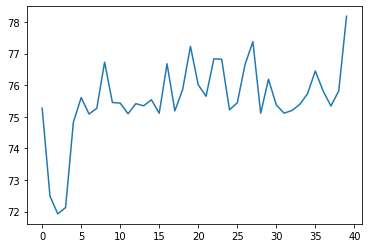

In [314]:
epoch_size = [x for x in range(epochs_number)]
plt.plot(epoch_size, costs)
    
print("Running Time Is: ", stop - timer)
print("Accuracy:" ,correct_guess / images_number)  